In [70]:
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

class Greedy(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))
    
class EpsilonGreedy(object):
    def __init__(self, n_arms, epsilon=0.1, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.epsilon = epsilon
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

class EpsilonDecreasing(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.epsilon = (2*self.n)
        self.epsilon /= (self.counts.sum() + 2*self.n)
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        self.epsilon = (2*self.n) 
        self.epsilon /= (self.counts.sum() + 2*self.n)
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))
    
class UCB(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        ucbs = [0.]*self.n
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ucb = p + self.delta*sqrt(2*T/n)
            ucbs[i] = ucb
        return np.argmax(ucbs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        ci = np.zeros(self.n)
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ci[i] = self.delta*sqrt(2*T/float(n))
        return zip(self.values, ci)

In [4]:
def wander(vec, delta=0.01, epsilon=0.1):
    for i in range(len(vec)):
        if random() < epsilon:
            if random() > 0.5:
                vec[i] += delta
            else:
                vec[i] -= delta
            if vec[i] > 1.0:
                vec[i] = 1.0
            elif vec[i] < 0:
                vec[i] = 0.0
            else:
                pass

#    return vec

def wander_periodic(vec, t, norm=50.0):
    new_vec = vec.copy()
    for i in range(new_vec.shape[0]):
        new_vec[i] = 0.5 + 0.5*math.sin(new_vec[t/norm])
    return new_vec

In [5]:
# create volatile data
def volatile_step(vec, p = 0.1):
    new_vec = np.copy(vec)
    news = np.zeros(vec.shape[0])
    for i in range(len(new_vec)):
        if random() > p: # stay alive
            news[i] = 0
        else: # replace
            new_vec[i] = random()
            news[i] = 1
    return new_vec, news

# takes 2 2d arrays, returns list of lists
def transform_volatile_for_plotting(actual, news):
    assert actual.shape == news.shape
    res = []
    rows, cols = actual.shape[0], actual.shape[1]
    for j in range(cols):
        inds = np.nonzero(news[:,j])[0].tolist()
        if inds[-1] != rows-1:
            inds.append(rows-1) # insure >= 2 1's
        bounds = zip(inds[:-1], inds[1:])
        for b in bounds:
            xs = range(b[0], b[1]+1)
            ys = actual[b[0]:b[1], j].tolist()
            ys.append(actual[b[1]-1,j])
            assert len(xs) == len(ys)
            res.append((xs, ys))
    return res

# function for plotting static data
# data like [[(x,y), (x,y)],[(x,y),...]]
def plot_volatile_data(data, ax=None, 
                            title='volatile rewards'):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,3))
    ax.set_title(title)
    ax.set_xlabel('time')
    ax.set_ylabel('reward')
    
    for i, d in enumerate(data):
        xs, ys = d
        ax.plot(xs, ys, linewidth=2, c='k')


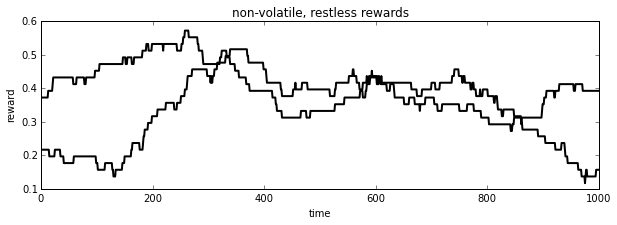

In [51]:
def gen_volatile_restless_data(k = 10, T = 300, 
                               p = 0.01, d = 0.01, 
                               e = 0.1):
    rewards = np.random.rand(k)
    steps = [rewards]
    news = [[1]*rewards.shape[0]]
    for t in range(T):
        r, nw = volatile_step(steps[-1], p)
        wander(r, d, e)
        steps.append(r)
        news.append(nw)
    return np.array(steps), np.array(news)

k, T = 2, 1000
data, news = gen_volatile_restless_data(k, T, p = 0.0,
                                        d = 0.02, e=0.1)
res = transform_volatile_for_plotting(data, news)
plot_volatile_data(res, title='non-volatile, restless rewards')

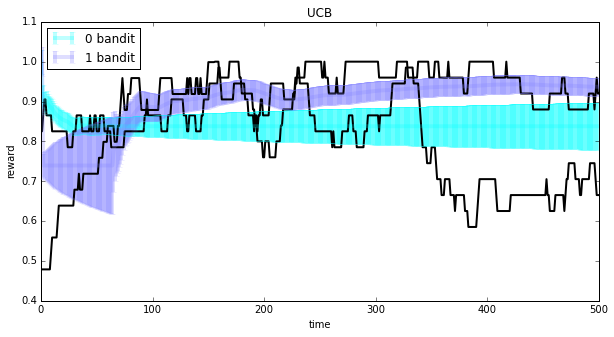

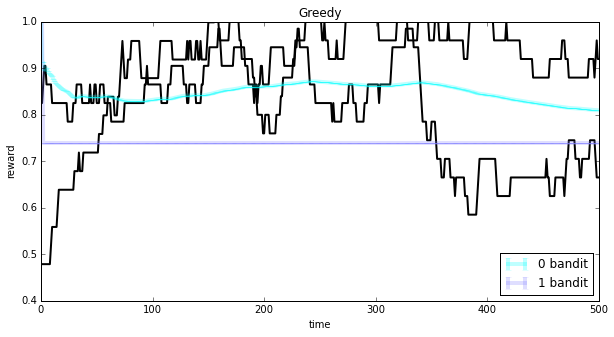

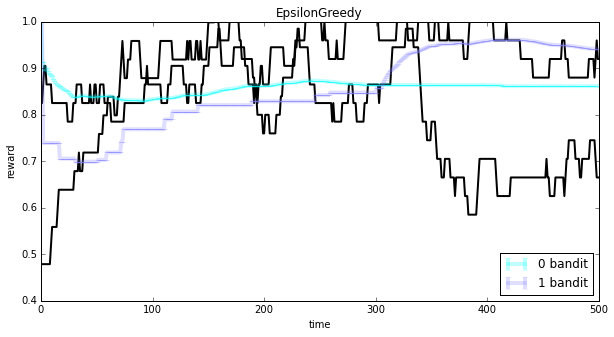

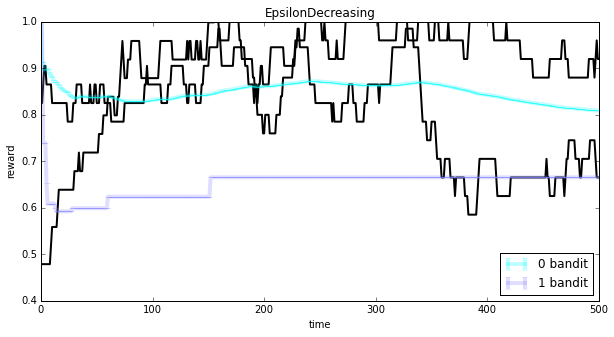

In [68]:
# test/sim for volatile bandit
def test_volatile(k = 2, T = 10, 
                actual = None,
                news = None,
                bandit = None):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros((T, k))
    choices = range(k)
    for t in range(T):
        ns = news[t]
        inds = np.nonzero(ns)
        for i in inds:
            bandit.reset_arm(i)
        arm = bandit.choose_arm()
        actual_best = np.max(actual[t])
        reward = actual[t][arm]
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret

def plot_arm_data_plus_actual(arm_data, actual, news, 
                              fs=(10,5), 
                              colormap = plt.cm.cool,
                              fig_title='title'):
    fig, ax = plt.subplots(figsize=fs)
    res = transform_volatile_for_plotting(actual, news)
    plot_volatile_data(res, ax)
    
    ax.set_title(fig_title); ax.grid('off')
    ax.set_xlabel('time'); ax.set_ylabel('reward')
    k = arm_data.shape[1]
    for i in range(k):
        color = colormap(i/float(k))
        xs = range(len(arm_data))
        ys = [e[i][0] for e in arm_data]
        err = [(e[i][1]) for e in arm_data]
        ax.errorbar(xs, ys, yerr=err, c=color, 
                    alpha=0.25, label=str(i)+' bandit',
                    linewidth=4)
    ax.legend(loc='best')

def demo_bandits():
    k, T = 2, 500
    actual, news = gen_volatile_restless_data(k, T, 
                                              p = 0.00,
                                              d = 0.04, 
                                              e=0.2)
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k)]
    for b in bandits:
        rewards, arm_data, regret = test_volatile(k, T, 
                                                  actual, 
                                                  news, b)
        bandit_name = b.__class__.__name__
        plot_arm_data_plus_actual(arm_data, actual, news, 
                                  fig_title=bandit_name)
        
demo_bandits()

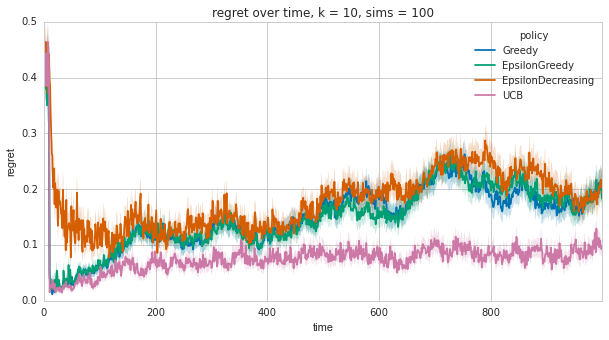

In [79]:
def sim():
    nsims = 100
    T = 1000
    k = 10
    bandits = [Greedy(k),
               EpsilonGreedy(k, 0.01),
               EpsilonDecreasing(k),
               UCB(k)]
    ts = pd.Series(range(T))
    df_final = None
    
    for sim in range(nsims):
        # set p = 0 for restless, non-volatile
        actual, news = gen_volatile_restless_data(k, T, 
                                              p = 0.00, 
                                              d = 0.07, 
                                              e=0.2)
        for i, bandit in enumerate(bandits):
            rewards, arm_data, regret = test_volatile(k, T, actual, 
                                                      news, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(nsims))
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', condition='policy', ax=ax)

sim()